# PASHA: Efficient HPO with Progressive Resource Allocation

Hyperparameter optimization (HPO) and neural architecture search (NAS) are methods of choice to obtain the best-in-class machine learning models, but in practice they can be costly to run. When models are trained on large datasets, tuning them with HPO or NAS rapidly becomes prohibitively expensive for practitioners, even when efficient multi-fidelity methods are employed. We propose an approach to tackle the challenge of tuning machine learning models trained on large datasets with limited computational resources. Our approach, named PASHA, extends ASHA and is able to dynamically allocate maximum resources for the tuning procedure depending on the need. The experimental comparison shows that PASHA identifies well-performing hyperparameter configurations and architectures while consuming significantly fewer computational resources than ASHA.

Outline:
* Initial pre-processing and exploration
* Main experiments on NASBench201- with PASHA, ASHA and the baselines
* Alternative ranking functions
* Changes to the reduction factor
* Combination with Bayesian Optimization

Start by importing the relevant libraries:

In [1]:
import json
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = False

from syne_tune.blackbox_repository import load_blackbox
from syne_tune.blackbox_repository.simulated_tabular_backend import BlackboxRepositoryBackend
from benchmarking.definitions.definition_nasbench201 import (
    nasbench201_benchmark,
    nasbench201_default_params
)
from syne_tune.backend.simulator_backend.simulator_callback import SimulatorCallback
from syne_tune.optimizer.schedulers.hyperband import HyperbandScheduler
from syne_tune.optimizer.baselines import baselines_dict
from syne_tune.tuner import Tuner
from syne_tune.stopping_criterion import StoppingCriterion
from syne_tune.experiments import load_experiment


Define our settings:

In [2]:
metric_valid_error_dim = 0
metric_runtime_dim = 2
dataset_names = ['cifar10', 'cifar100', 'ImageNet16-120']
epoch_names = ['val_acc_epoch_' + str(e) for e in range(200)]
random_seeds = [31415927, 0, 1234, 3458, 7685]
nb201_random_seeds = [0, 1, 2]
n_workers = 4

# Initial pre-processing and exploration

Load NASBench201 benchmark so that we can analyse the performance of various approaches:

In [3]:
bb_dict = {}
for dataset in dataset_names:
    bb_dict[dataset] = load_blackbox(dataset)[dataset]

df_dict = {}

for seed in nb201_random_seeds:
    df_dict[seed] = {}
    for dataset in dataset_names:
        # create a dataframe with the validation accuracies for various epochs
        df_val_acc = pd.DataFrame((1.0-bb_dict[dataset].objectives_evaluations[:, seed, :, metric_valid_error_dim])
                                  * 100, columns=['val_acc_epoch_' + str(e) for e in range(200)])

        # add a new column with the best validation accuracy
        df_val_acc['val_acc_best'] = df_val_acc[epoch_names].max(axis=1)
        # create a dataframe with the hyperparameter values
        df_hp = bb_dict[dataset].hyperparameters
        # create a dataframe with the times it takes to run an epoch
        df_time = pd.DataFrame(bb_dict[dataset].objectives_evaluations[:, seed, :, metric_runtime_dim][:, -1], columns=['eval_time_epoch'])    
        # combine all smaller dataframes into one dataframe for each NASBench201 random seed and dataset
        df_dict[seed][dataset] = pd.concat([df_hp, df_val_acc, df_time], axis=1)


Motivation to measure best validation accuracy: NASBench201 provides validation and test errors in an inconsistent format and in fact we can only get the errors for each epoch on their combined validation and test sets for CIFAR-100 and ImageNet16-120. As a trade-off, we use the combined validation and test sets as the validation set. Consequently, there is no test set which we can use for additional evaluation and so we use the best validation accuracy as the final evaluation metric.

Have a look at what the dataframes look like:

In [4]:
df_dict[0]['cifar10']

,hp_x0,hp_x1,hp_x2,hp_x3,hp_x4,hp_x5,val_acc_epoch_0,val_acc_epoch_1,val_acc_epoch_2,val_acc_epoch_3,...,val_acc_epoch_192,val_acc_epoch_193,val_acc_epoch_194,val_acc_epoch_195,val_acc_epoch_196,val_acc_epoch_197,val_acc_epoch_198,val_acc_epoch_199,val_acc_best,eval_time_epoch
0,avg_pool_3x3,nor_conv_1x1,skip_connect,nor_conv_1x1,skip_connect,skip_connect,37.980003,36.909996,38.739998,31.059998,...,85.469994,85.479996,85.699997,85.689995,85.570000,85.639999,85.659996,85.619995,85.729996,15.461778
1,nor_conv_3x3,nor_conv_3x3,avg_pool_3x3,skip_connect,nor_conv_3x3,skip_connect,34.619999,61.129997,61.039997,70.029999,...,93.739998,93.739998,93.729996,93.709999,93.739998,93.729996,93.639999,93.750000,93.750000,23.198093
2,avg_pool_3x3,nor_conv_3x3,nor_conv_3x3,avg_pool_3x3,avg_pool_3x3,avg_pool_3x3,36.389999,44.279999,42.290001,42.139999,...,86.029999,85.790001,85.820000,85.959999,85.870003,85.699997,85.769997,85.839996,86.029999,24.261475
3,avg_pool_3x3,skip_connect,none,none,none,skip_connect,37.349998,48.919998,56.320000,59.029995,...,86.870003,86.779999,86.790001,86.830002,86.870003,86.720001,86.790001,86.809998,86.989998,9.305114
4,skip_connect,skip_connect,nor_conv_1x1,skip_connect,skip_connect,nor_conv_1x1,35.450001,36.369999,32.860001,34.069996,...,87.900002,88.199997,88.160004,88.099998,87.989998,88.070000,88.209999,88.090004,88.209999,13.933862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,none,avg_pool_3x3,avg_pool_3x3,skip_connect,skip_connect,none,40.399998,47.910000,58.350002,56.389999,...,86.449997,86.529999,86.489998,86.660004,86.639999,86.669998,86.559998,86.619995,86.669998,11.035928
15621,avg_pool_3x3,nor_conv_3x3,nor_conv_3x3,skip_connect,nor_conv_1x1,none,36.619995,51.030003,60.530003,45.649998,...,88.489998,88.459999,88.700005,88.610001,88.510002,88.510002,88.669998,88.400002,88.700005,22.097097
15622,skip_connect,nor_conv_3x3,nor_conv_3x3,nor_conv_3x3,none,nor_conv_1x1,37.989998,45.160000,48.240002,55.739998,...,92.779999,92.769997,92.809998,92.750000,92.720001,92.729996,92.769997,92.779999,92.849998,24.775816
15623,none,avg_pool_3x3,avg_pool_3x3,avg_pool_3x3,none,avg_pool_3x3,20.420002,29.619997,21.740002,25.230003,...,69.110001,68.739998,69.089996,69.330002,69.449997,69.459999,69.420006,69.480003,69.480003,14.217638


Perform brief exploratory analysis to show NAS is helpful:

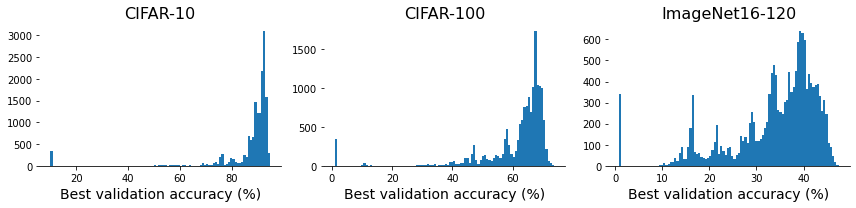

In [7]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.hist(df_dict[0]['cifar10']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('CIFAR-10', fontsize=16)

plt.subplot(132)
plt.hist(df_dict[0]['cifar100']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('CIFAR-100', fontsize=16)

plt.subplot(133)
plt.hist(df_dict[0]['ImageNet16-120']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('ImageNet16-120', fontsize=16)
plt.tight_layout()
plt.show()

We can clearly see that there is a huge difference between the various configurations, so NAS is important.

## Main experiments
We perform experiments on NASBench201 - CIFAR-10, CIFAR-100 and ImageNet16-120 datasets. We use PASHA, ASHA (promotion type) and the relevant baselines - one epoch and random.

Grace period is the name for minimum resources in SyneTune.

Define functions for running the experiments and analysing them:

In [8]:
def run_experiment(dataset_name, random_seed, benchmark_random_seed, hpo_approach, reduction_factor=None, rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.025}, benchmark_metric='metric_valid_error', benchmark='nasbench201', benchmark_mode=None):
    """
    Function to run an experiment. It is similar to the NASBench201 example script
    in syne-tune but extended to make it simple to run our experiments.
    
    When describing the following parameters we say what values we use, but feel free to also use other values.
    
    :param dataset_name: one of 'cifar10', 'cifar100', 'ImageNet16-120'
    :param random_seed: one of 31415927, 0, 1234, 3458, 7685
    :param benchmark_random_seed: one of 0, 1, 2 for nasbench201 and 0 for lcbench
    :param hpo_approach: one of 'pasha', 'asha', 'pasha-bo', 'asha-bo'
    :param reduction_factor: by default None (resulting in using the default value 3) or 2, 4
    :param rung_system_kwargs: dictionary of ranking criterion (str) and epsilon or epsilon scaling (both float)
    :return: tuner.name
    
    """
    
    # this function is similar to the NASBench201 example script
    logging.getLogger().setLevel(logging.WARNING)

    default_params = nasbench201_default_params({'backend': 'simulated'})
    benchmark = nasbench201_benchmark(default_params)
    resource_attr = benchmark['resource_attr']
    max_t = default_params['max_resource_level']
    blackbox_name = dataset_name
    # NASBench201 is a blackbox from the repository
    assert blackbox_name is not None
    elapsed_time_attr = 'elapsed_time'
    surrogate = None
        
    # benchmark must be tabulated to support simulation
    assert benchmark.get('supports_simulated', False)
    if benchmark_mode:
        mode = benchmark_mode
    else:
        mode = benchmark['mode']
    
    metric = benchmark_metric  # benchmark['metric']

    config_space = benchmark['config_space']
    config_space['dataset_name'] = dataset_name

    # simulator back-end specialized to tabulated blackboxes
    trial_backend = BlackboxRepositoryBackend(
        blackbox_name=blackbox_name,
        elapsed_time_attr=elapsed_time_attr,
        dataset=dataset_name,
        seed=benchmark_random_seed,
        surrogate=surrogate)

    # set logging of the simulator backend to WARNING level
    logging.getLogger('syne_tune.backend.simulator_backend.simulator_backend').setLevel(logging.WARNING)
    
    if not reduction_factor:
        reduction_factor = default_params['reduction_factor']
            
    # we support various schedulers within the function
    # NOTE: previously we used resource_attr instead of max_resource_attr
    if hpo_approach == 'pasha':
        scheduler = baselines_dict['PASHA'](
            config_space,
            max_t=max_t,
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha':
        scheduler = baselines_dict['ASHA'](
            config_space,
            max_t=max_t,
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    elif hpo_approach == 'pasha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=max_t,
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            searcher='bayesopt',
            type='pasha',
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=max_t,
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            searcher='bayesopt',
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    else:
        raise ValueError('The selected scheduler is not implemented')

    stop_criterion = StoppingCriterion(max_num_trials_started=256)
    # printing the status during tuning takes a lot of time, and so does
    # storing results
    print_update_interval = 7000
    results_update_interval = 3000
    # it is important to set `sleep_time` to 0 here (mandatory for simulator
    # backend)

    tuner = Tuner(
        trial_backend=trial_backend,
        scheduler=scheduler,
        stop_criterion=stop_criterion,
        n_workers=n_workers,
        sleep_time=0,
        results_update_interval=results_update_interval,
        print_update_interval=print_update_interval,
        # this callback is required in order to make things work with the
        # simulator callback. It makes sure that results are stored with
        # simulated time (rather than real time), and that the time_keeper
        # is advanced properly whenever the tuner loop sleeps
        callbacks=[SimulatorCallback()],
    )
    
    tuner.run()
    
    return tuner.name

In [9]:
def analyse_experiments(experiment_names_dict, reference_time=None):
    """
    Function to analyse the experiments that we run with run_experiment function.
    
    :param experiment_names_dict: dictionary mapping the dataset names to tuples of
        experiment names and NASBench201 random seeds
    :reference_time: optional argument with the time it takes to run the standard method - e.g. ASHA
    :return: tuple of a line to display (string reporting the experiment results) and 
        the mean of the runtimes that can be used as reference time for other approaches
    """
    val_acc_best_list = []
    max_rsc_list = []
    runtime_list = []
    
    for experiment_name, nb201_random_seed in experiment_names_dict[dataset_name]:
        experiment_results = load_experiment(experiment_name)
        best_cfg = experiment_results.results['metric_valid_error'].argmin()
        
        # find the best validation accuracy of the corresponding entry in NASBench201
        table_hp_names = ['hp_x' + str(hp_idx) for hp_idx in range(6)]
        results_hp_names = ['config_hp_x' + str(hp_idx) for hp_idx in range(6)]
        condition = (df_dict[nb201_random_seed][dataset_name][table_hp_names] == experiment_results.results[results_hp_names].iloc[best_cfg].tolist()).all(axis=1)
        val_acc_best = df_dict[nb201_random_seed][dataset_name][condition]['val_acc_best'].values[0]  # there is only one item in the list
        val_acc_best_list.append(val_acc_best)
        max_rsc_list.append(experiment_results.results['hp_epoch'].max())
        runtime_list.append(experiment_results.results['st_tuner_time'].max())
        
    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(val_acc_best_list), np.std(val_acc_best_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(runtime_list)/3600, np.std(runtime_list)/3600)
    if reference_time:
        line += ' & {:.1f}x'.format(reference_time/np.mean(runtime_list))
    else:
        line += ' & {:.1f}x'.format(np.mean(runtime_list)/np.mean(runtime_list))
    line += ' & {:.1f} $\pm$ {:.1f}'.format(np.mean(max_rsc_list), np.std(max_rsc_list))
    
    return line, np.mean(runtime_list)

In [10]:
def compute_one_epoch_baseline(metric='val_acc'):
    """
    Function to compute the performance of a simple one epoch baseline.
    :return: a line to display (string reporting the experiment results)
    """
    best_val_obj_list = []
    total_time_list = []
    
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            # randomly sample 256 configurations for the given dataset and NASBench201 seed
            # use the same seeds as for our other experiments
            random.seed(random_seed)
            cfg_list = random.sample(range(len(df_dict[nb201_random_seed][dataset_name])), 256)
            selected_subset = df_dict[nb201_random_seed][dataset_name].iloc[cfg_list]
            # find configuration with the best performance after doing one epoch
            max_idx = selected_subset[metric + '_epoch_0'].argmax()
            best_configuration = selected_subset.iloc[max_idx]
            # find the best validation accuracy of the selected configuration
            # as that is the metric that we compare 
            best_val_obj = best_configuration[epoch_names].max()

            # we also need to calculate the time it took for this
            # taking into account the number of workers
            total_time = selected_subset['eval_time_epoch'].sum() / n_workers

            best_val_obj_list.append(best_val_obj)
            total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(best_val_obj_list), np.std(best_val_obj_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & {:.1f}x'.format(reference_time/np.mean(total_time_list))
    line += ' & 1.0 $\pm$ 0.0'

    return line

In [11]:
def compute_random_baseline():
    """
    Function to compute the performance of a simple random configuration baseline.
    
    We consider a ten times larger number of configurations in this case to get a better
    estimate of the performance of a random configuration.

    :return: a line to display (string reporting the experiment results)
    """
    random.seed(0)
    random_seeds_rb = random.sample(range(999999), 256 * 10)

    best_val_obj_list = []
    total_time_list = []

    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds_rb:
            random.seed(random_seed)
            # select the random configurations
            cfg_list = random.sample(range(len(df_dict[nb201_random_seed][dataset_name])), 1)
            selected_configuration = df_dict[nb201_random_seed][dataset_name].iloc[cfg_list]
            # find the best validation accuracy of the selected configuration
            # as that is the metric that we compare 
            best_val_obj = selected_configuration[epoch_names].max()

            # we also need to calculate the time it took for this
            total_time = 0.0

            best_val_obj_list.append(best_val_obj)
            total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(best_val_obj_list), np.std(best_val_obj_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & NA'
    line += ' & 0.0 $\pm$ 0.0'

    return line

Run the main experiments with PASHA, ASHA and the baselines

In [12]:
%%capture

experiment_names_asha_val_acc = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_val_acc_auto = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha', benchmark_metric='metric_valid_error')
            experiment_names_asha_val_acc[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', benchmark_metric='metric_valid_error', rung_system_kwargs={'ranking_criterion': 'soft_ranking_auto', 'epsilon': 0.0})
            experiment_names_pasha_val_acc_auto[dataset_name].append((experiment_name, nb201_random_seed))

Analyse the experiments:

In [14]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_val_acc)
    print('ASHA VACC' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_val_acc_auto, reference_time)
    print('PASHA VACC-AUTO' + result_summary)
    result_summary = compute_one_epoch_baseline()
    print('One epoch baseline VACC', result_summary)
    result_summary = compute_random_baseline()
    print('Random baseline', result_summary)
    

cifar10
ASHA VACC & 93.85 $\pm$ 0.25 & 3.0h $\pm$ 0.6h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 93.57 $\pm$ 0.75 & 1.3h $\pm$ 0.6h & 2.3x & 36.1 $\pm$ 50.0
One epoch baseline VACC  & 93.30 $\pm$ 0.61 & 0.3h $\pm$ 0.0h & 8.5x & 1.0 $\pm$ 0.0
Random baseline  & 72.93 $\pm$ 19.55 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
cifar100
ASHA VACC & 71.69 $\pm$ 1.05 & 3.2h $\pm$ 0.9h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 71.84 $\pm$ 1.41 & 0.9h $\pm$ 0.4h & 3.4x & 20.5 $\pm$ 48.3
One epoch baseline VACC  & 65.57 $\pm$ 5.53 & 0.3h $\pm$ 0.0h & 9.2x & 1.0 $\pm$ 0.0
Random baseline  & 42.98 $\pm$ 18.34 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
ImageNet16-120
ASHA VACC & 45.63 $\pm$ 0.81 & 8.8h $\pm$ 2.2h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 45.13 $\pm$ 1.51 & 2.9h $\pm$ 1.7h & 3.1x & 21.3 $\pm$ 48.1
One epoch baseline VACC  & 41.42 $\pm$ 4.98 & 1.0h $\pm$ 0.0h & 8.8x & 1.0 $\pm$ 0.0
Random baseline  & 20.97 $\pm$ 10.01 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0


Next we do experiments with different pruning ratios - 2 and 4.

In [15]:
%%capture

experiment_names_asha_vacc_2 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_vacc_auto_2 = {dataset: [] for dataset in dataset_names}
experiment_names_asha_vacc_4 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_vacc_auto_4 = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha', benchmark_metric='metric_valid_error', reduction_factor=2)
            experiment_names_asha_vacc_2[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', benchmark_metric='metric_valid_error', rung_system_kwargs={'ranking_criterion': 'soft_ranking_auto', 'epsilon': 0.0}, reduction_factor=2)
            experiment_names_pasha_vacc_auto_2[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha', benchmark_metric='metric_valid_error', reduction_factor=4)
            experiment_names_asha_vacc_4[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', benchmark_metric='metric_valid_error', rung_system_kwargs={'ranking_criterion': 'soft_ranking_auto', 'epsilon': 0.0}, reduction_factor=4)
            experiment_names_pasha_vacc_auto_4[dataset_name].append((experiment_name, nb201_random_seed))

In [16]:
print('Resource level 2')
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_vacc_2)
    print('ASHA VACC' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_vacc_auto_2, reference_time)
    print('PASHA VACC-AUTO' + result_summary)

print('Resource level 4')
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_vacc_4)
    print('ASHA VACC' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_vacc_auto_4, reference_time)
    print('PASHA VACC-AUTO' + result_summary)

Resource level 2
cifar10
ASHA VACC & 93.88 $\pm$ 0.27 & 3.6h $\pm$ 1.1h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 93.53 $\pm$ 0.76 & 1.0h $\pm$ 0.3h & 3.5x & 9.1 $\pm$ 8.1
cifar100
ASHA VACC & 71.67 $\pm$ 0.84 & 3.8h $\pm$ 1.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 71.65 $\pm$ 1.42 & 0.9h $\pm$ 0.1h & 4.2x & 5.9 $\pm$ 2.0
ImageNet16-120
ASHA VACC & 46.09 $\pm$ 0.68 & 11.9h $\pm$ 4.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 45.35 $\pm$ 1.52 & 2.8h $\pm$ 0.6h & 4.2x & 9.3 $\pm$ 7.1
Resource level 4
cifar10
ASHA VACC & 93.75 $\pm$ 0.28 & 2.4h $\pm$ 0.6h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 93.65 $\pm$ 0.65 & 1.1h $\pm$ 0.5h & 2.3x & 32.3 $\pm$ 50.2
cifar100
ASHA VACC & 71.43 $\pm$ 1.13 & 2.7h $\pm$ 0.9h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 72.09 $\pm$ 1.22 & 1.0h $\pm$ 0.4h & 2.8x & 25.1 $\pm$ 49.0
ImageNet16-120
ASHA VACC & 45.43 $\pm$ 0.98 & 7.9h $\pm$ 3.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA VACC-AUTO & 45.52 $\pm$ 1.30 & 2.9h $\pm$ 1.1h & 2.8x & 18.4 $\pm$ 18.7


Analysis of the BO experiments:

In [17]:
# need to load the names of the configurations from the json file where we store it
with open('bo_experiment_details_auto_vacc.json', 'r') as f:
    bo_experiment_details = json.load(f)

experiment_names_pasha_bo = {dataset: [] for dataset in dataset_names}
experiment_names_asha_bo = {dataset: [] for dataset in dataset_names}

# load the details of the experiments
for detail_dict in bo_experiment_details:
    if detail_dict['scheduler'] == 'asha-bo':
        experiment_names_asha_bo[detail_dict['dataset_name']].append((detail_dict['experiment_name'], detail_dict['nb201_random_seed']))
    elif detail_dict['scheduler'] == 'pasha-bo':
        experiment_names_pasha_bo[detail_dict['dataset_name']].append((detail_dict['experiment_name'], detail_dict['nb201_random_seed']))

In [18]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_bo)
    print('ASHA' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_bo, reference_time)
    print('PASHA' + result_summary)
    

cifar10
ASHA & 94.21 $\pm$ 0.28 & 5.0h $\pm$ 1.1h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 94.00 $\pm$ 0.20 & 2.6h $\pm$ 1.8h & 2.0x & 70.7 $\pm$ 81.6
cifar100
ASHA & 72.79 $\pm$ 0.68 & 5.7h $\pm$ 1.4h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 72.16 $\pm$ 1.07 & 1.6h $\pm$ 0.5h & 3.7x & 13.0 $\pm$ 8.7
ImageNet16-120
ASHA & 46.21 $\pm$ 0.70 & 15.1h $\pm$ 4.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 45.36 $\pm$ 1.06 & 3.9h $\pm$ 1.2h & 3.9x & 11.8 $\pm$ 7.9


## PD1 experiments and evaluation

In [19]:
from syne_tune.blackbox_repository.conversion_scripts.scripts.pd1_import import (
    BLACKBOX_NAME, COLUMN_RENAMING, CONFIGURATION_SPACE, METRIC_ELAPSED_TIME,
    METRIC_VALID_ERROR, RESOURCE_ATTR)

from syne_tune.blackbox_repository import add_surrogate

In [20]:
bb_dict = load_blackbox('pd1')

In [21]:
metric_valid_error_dim = 0
metric_runtime_dim = 2
dataset_names = ['imagenet_resnet_batch_size_512', 'translate_wmt_xformer_translate_batch_size_64']
random_seeds = [31415927, 0, 1234, 3458, 7685]
n_workers = 4

df_dict = {0: {}}
seed = 0

for dataset in dataset_names:
    num_epochs = bb_dict[dataset].objectives_evaluations.shape[2]
    epoch_names = ['val_acc_epoch_' + str(e) for e in range(num_epochs)]
    # create a dataframe with the validation accuracies for various epochs
    df_val_acc = pd.DataFrame((1.0-bb_dict[dataset].objectives_evaluations[:, seed, :, metric_valid_error_dim]) * 100, columns=['val_acc_epoch_' + str(e) for e in range(num_epochs)])
    
    # add a new column with the best validation accuracy
    df_val_acc['val_acc_best'] = df_val_acc[epoch_names].max(axis=1)
    # create a dataframe with the hyperparameter values
    df_hp = bb_dict[dataset].hyperparameters
    # create a dataframe with the times it takes to run an epoch
    df_time = pd.DataFrame(bb_dict[dataset].objectives_evaluations[:, seed, :, metric_runtime_dim][:, -1]/bb_dict[dataset].objectives_evaluations.shape[2], columns=['eval_time_epoch'])    
    # combine all smaller dataframes into one dataframe for each random seed and dataset
    df_dict[seed][dataset] = pd.concat([df_hp, df_val_acc, df_time], axis=1)

In [22]:
df_dict[0]['imagenet_resnet_batch_size_512']

,lr_initial_value,lr_power,lr_decay_steps_factor,one_minus_momentum,val_acc_epoch_0,val_acc_epoch_1,val_acc_epoch_2,val_acc_epoch_3,val_acc_epoch_4,val_acc_epoch_5,...,val_acc_epoch_243,val_acc_epoch_244,val_acc_epoch_245,val_acc_epoch_246,val_acc_epoch_247,val_acc_epoch_248,val_acc_epoch_249,val_acc_epoch_250,val_acc_best,eval_time_epoch
0,0.000333,1.154020,0.234034,0.975224,1.286024,2.010041,2.224046,2.524048,2.786058,2.970058,...,8.250165,8.234167,8.312166,8.252168,8.240164,8.238167,8.264166,8.262163,8.312166,26.908581
1,0.000293,0.572230,0.455548,0.905727,0.490010,0.830019,1.052022,1.258028,1.420027,1.628035,...,5.924118,5.934119,5.912119,5.930120,5.928117,5.912119,5.904120,5.928117,5.946117,29.569784
2,0.000285,0.175994,0.681017,0.568908,0.134003,0.184005,0.316006,0.398010,0.512010,0.566012,...,3.484070,3.440070,3.478068,3.488070,3.476071,3.462070,3.440070,3.460068,3.504068,25.339344
3,0.000018,1.770602,0.431815,0.492782,0.130004,0.132000,0.128001,0.124002,0.126004,0.124002,...,0.296009,0.296009,0.296009,0.296009,0.294006,0.298005,0.296009,0.300008,0.302005,31.448215
4,0.000503,1.103766,0.943076,0.997958,2.498049,4.536092,6.342125,8.362168,10.474211,12.362247,...,74.217484,74.211487,74.199486,74.177483,74.161484,74.143478,74.209488,74.145485,74.217484,29.043724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,0.217098,1.562599,0.772744,0.903084,8.954180,17.652351,22.806454,30.388605,34.288685,34.964699,...,76.943542,77.073540,77.005539,77.041542,77.031540,77.025536,77.021538,77.021538,77.073540,44.679020
2077,5.645541,0.773464,0.018352,0.958217,0.842017,2.046043,5.194104,10.298204,24.756496,25.840515,...,68.311371,68.521370,68.397369,68.279358,68.117363,68.487373,68.659378,68.233368,68.659378,44.041317
2078,1.208451,1.753618,0.819584,0.998627,0.104004,0.988019,0.566012,0.846016,0.758016,0.704014,...,29.752594,29.802597,30.206602,29.858595,30.326605,30.574614,30.328608,30.998617,30.998617,52.782589
2079,0.382426,1.843956,0.267077,0.216799,4.538089,8.152163,10.762215,14.936298,17.936361,19.718397,...,67.847359,67.841354,67.791351,67.807350,67.775360,67.813362,67.777359,67.775360,67.847359,45.980042


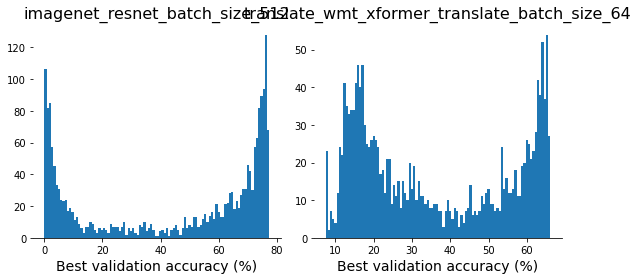

In [23]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(df_dict[0]['imagenet_resnet_batch_size_512']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('imagenet_resnet_batch_size_512', fontsize=16)

plt.subplot(122)
plt.hist(df_dict[0]['translate_wmt_xformer_translate_batch_size_64']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('translate_wmt_xformer_translate_batch_size_64', fontsize=16)
plt.tight_layout()
plt.show()

This looks good so far

In [24]:
def run_experiment_pd1(dataset_name, random_seed, benchmark_random_seed, hpo_approach, reduction_factor=None, rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.025}, benchmark_metric='metric_valid_error', benchmark='nasbench201', benchmark_mode=None):
    """
    Function to run an experiment. It is similar to the NASBench201 example script
    in syne-tune but extended to make it simple to run our experiments.
    
    When describing the following parameters we say what values we use, but feel free to also use other values.
    
    :param dataset_name: one of 'imagenet_resnet_batch_size_512', 'translate_wmt_xformer_translate_batch_size_64'
    :param random_seed: one of 31415927, 0, 1234, 3458, 7685
    :param benchmark_random_seed: 0
    :param hpo_approach: one of 'pasha', 'asha', 'pasha-bo', 'asha-bo'
    :param reduction_factor: by default None (resulting in using the default value 3) or 2, 4
    :param rung_system_kwargs: dictionary of ranking criterion (str) and epsilon or epsilon scaling (both float)
    :return: tuner.name
    
    """
    
    # this function is similar to the NASBench201 example script
    logging.getLogger().setLevel(logging.WARNING)
    
    n_workers = 4
    resource_attr = RESOURCE_ATTR
    blackbox_name = BLACKBOX_NAME
    elapsed_time_attr = METRIC_ELAPSED_TIME
    surrogate = "KNeighborsRegressor"
    surrogate_kwargs = {"n_neighbors": 1}

    metric = benchmark_metric  # benchmark['metric']

    config_space = CONFIGURATION_SPACE
    config_space['dataset_name'] = dataset_name

    max_t_dict = {'imagenet_resnet_batch_size_512': 251,
                  'translate_wmt_xformer_translate_batch_size_64': 1414}

    max_t = max_t_dict[dataset_name]
    grace_period = 1
    
    if benchmark_mode:
        mode = benchmark_mode
    else:
        mode = 'min'

    # simulator back-end specialized to tabulated blackboxes
    trial_backend = BlackboxRepositoryBackend(
        blackbox_name=blackbox_name,
        elapsed_time_attr=elapsed_time_attr,
        dataset=dataset_name,
        seed=benchmark_random_seed,
        surrogate=surrogate, surrogate_kwargs=surrogate_kwargs)

    # set logging of the simulator backend to WARNING level
    logging.getLogger('syne_tune.backend.simulator_backend.simulator_backend').setLevel(logging.WARNING)
    
    if not reduction_factor:
        reduction_factor = 3
            
    # we support various schedulers within the function
    # NOTE: previously we used resource_attr instead of max_resource_attr
    if hpo_approach == 'pasha':
        scheduler = baselines_dict['PASHA'](
            config_space,
            max_t=max_t,
            grace_period=grace_period,
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha':
        scheduler = baselines_dict['ASHA'](
            config_space,
            max_t=max_t,
            grace_period=grace_period,
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    elif hpo_approach == 'pasha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=max_t,
            grace_period=grace_period,
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            searcher='bayesopt',
            type='pasha',
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=max_t,
            grace_period=grace_period,
            reduction_factor=reduction_factor,
            resource_attr=resource_attr,
            mode=mode,
            searcher='bayesopt',
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    else:
        raise ValueError('The selected scheduler is not implemented')

    stop_criterion = StoppingCriterion(max_num_trials_started=256)

    tuner = Tuner(
        trial_backend=trial_backend,
        scheduler=scheduler,
        stop_criterion=stop_criterion,
        n_workers=n_workers,
        sleep_time=0,
        callbacks=[SimulatorCallback()],
    )
    
    tuner.run()
    
    return tuner.name

In [25]:
def analyse_experiments_pd1(experiment_names_dict, reference_time=None):
    """
    Function to analyse the experiments that we run with run_experiment function.
    
    :param experiment_names_dict: dictionary mapping the dataset names to tuples of
        experiment names and NASBench201 random seeds
    :reference_time: optional argument with the time it takes to run the standard method - e.g. ASHA
    :return: tuple of a line to display (string reporting the experiment results) and 
        the mean of the runtimes that can be used as reference time for other approaches
    """
    val_acc_best_list = []
    max_rsc_list = []
    runtime_list = []
    bbs = add_surrogate(bb_dict[dataset_name], surrogate=None)
    
    for experiment_name, nb201_random_seed in experiment_names_dict[dataset_name]:
        experiment_results = load_experiment(experiment_name)
        best_cfg = experiment_results.results['metric_valid_error_rate'].argmin()

        # find the test accuracy of the corresponding entry
        table_hp_names = ['lr_initial_value', 'lr_power', 'lr_decay_steps_factor', 'one_minus_momentum']
        results_hp_names = ['config_' + str(hp_name) for hp_name in table_hp_names]
        best_cfg_hps = experiment_results.results[results_hp_names].iloc[best_cfg].tolist()
        best_cfg_hps_dict = {k:v for k, v in zip(table_hp_names, best_cfg_hps)} 
        
        val_acc_best = bbs.objective_function(best_cfg_hps_dict)[:, metric_valid_error_dim].min()
        val_acc_best_list.append((1.0 - val_acc_best) * 100.0)
        
        max_rsc_list.append(experiment_results.results['global_step'].max())
        runtime_list.append(experiment_results.results['st_tuner_time'].max())
        
    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(val_acc_best_list), np.std(val_acc_best_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(runtime_list)/3600, np.std(runtime_list)/3600)
    if reference_time:
        line += ' & {:.1f}x'.format(reference_time/np.mean(runtime_list))
    else:
        line += ' & {:.1f}x'.format(np.mean(runtime_list)/np.mean(runtime_list))
    line += ' & {:.1f} $\pm$ {:.1f}'.format(np.mean(max_rsc_list), np.std(max_rsc_list))
    
    return line, np.mean(runtime_list)

In [26]:
def compute_one_epoch_baseline_pd1(dataset_name, metric='val_err'):
    """
    Function to compute the performance of a simple one epoch baseline.
    :return: a line to display (string reporting the experiment results)
    """  
    val_acc_best_list = []
    total_time_list = []
        
    bbs = add_surrogate(bb_dict[dataset_name], surrogate=None)

    for random_seed in random_seeds:
        random.seed(random_seed)
        random_seeds_rb = random.sample(range(999999), 256)
        time_sum = 0.0

        if metric == 'val_err':
            metric_score_dim = metric_valid_error_dim
            benchmark_mode = 'min'
            best_metric_score = 10000.0
            best_hps = None
        else:
            raise ValueError('Metric ' + metric + ' currently not supported')

        for random_seed_rb in random_seeds_rb:
            np.random.seed(random_seed_rb)
            sampled_hps = {k: v.sample() for k, v in bb_dict[dataset_name].configuration_space.items()}
            metric_score = bbs.objective_function(sampled_hps)[0, metric_score_dim]
            time_sum += bbs.objective_function(sampled_hps)[0, metric_runtime_dim]

            if benchmark_mode == 'min':
                if metric_score < best_metric_score:
                    best_metric_score = metric_score
                    best_hps = sampled_hps
            else:
                if metric_score > best_metric_score:
                    best_metric_score = metric_score
                    best_hps = sampled_hps

        # now we have found the best configuration
        # the dataframe contains validation error rates
        val_acc_best = bbs.objective_function(best_hps)[:, metric_score_dim].min()
        val_acc_best_list.append((1.0 - val_acc_best) * 100.0)

        # we also need to calculate the time it took for this
        # taking into account the number of workers
        total_time = time_sum / n_workers
        total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(val_acc_best_list), np.std(val_acc_best_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & {:.1f}x'.format(reference_time/np.mean(total_time_list))
    line += ' & 1.0 $\pm$ 0.0'

    return line

In [27]:
def compute_random_baseline_pd1(dataset_name):
    """
    Function to compute the performance of a simple random configuration baseline.
    
    We consider a ten times larger number of configurations in this case to get a better
    estimate of the performance of a random configuration.

    :return: a line to display (string reporting the experiment results)
    """
    val_acc_best_list = []
    total_time_list = []
    metric_score_dim = metric_valid_error_dim

    random.seed(0)
    random_seeds_rb = random.sample(range(999999), 256 * 10)

    bbs = add_surrogate(bb_dict[dataset_name], surrogate=None)

    for random_seed in random_seeds_rb:
        np.random.seed(random_seed)
        sampled_hps = {k: v.sample() for k, v in bb_dict[dataset_name].configuration_space.items()}
        val_acc_best = bbs.objective_function(sampled_hps)[:, metric_score_dim].min()
        val_acc_best_list.append((1.0 - val_acc_best) * 100.0)

        # we also need to calculate the time it took for this
        total_time = 0.0
        total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(val_acc_best_list), np.std(val_acc_best_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & NA'
    line += ' & 0.0 $\pm$ 0.0'

    return line

Now do the experiments:

In [28]:
%%capture

experiment_names_asha_val_acc = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_val_acc_auto = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in [0]:
        for random_seed in random_seeds:
            experiment_name = run_experiment_pd1(dataset_name, random_seed, nb201_random_seed, 'asha', benchmark_metric='metric_valid_error_rate')
            experiment_names_asha_val_acc[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment_pd1(dataset_name, random_seed, nb201_random_seed, 'pasha', benchmark_metric='metric_valid_error_rate', rung_system_kwargs={'ranking_criterion': 'soft_ranking_auto', 'epsilon': 0.0})
            experiment_names_pasha_val_acc_auto[dataset_name].append((experiment_name, nb201_random_seed))

In [29]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments_pd1(experiment_names_asha_val_acc)
    print('ASHA VACC' + result_summary)
    result_summary, _ = analyse_experiments_pd1(experiment_names_pasha_val_acc_auto, reference_time)
    print('PASHA VACC-AUTO' + result_summary)
    result_summary = compute_one_epoch_baseline_pd1(dataset_name)
    print('One epoch baseline VACC', result_summary)
    result_summary = compute_random_baseline_pd1(dataset_name)
    print('Random baseline', result_summary)

imagenet_resnet_batch_size_512
ASHA VACC & 75.10 $\pm$ 2.03 & 7.3h $\pm$ 1.2h & 1.0x & 251.0 $\pm$ 0.0
PASHA VACC-AUTO & 73.37 $\pm$ 2.71 & 3.8h $\pm$ 1.0h & 1.9x & 45.0 $\pm$ 30.1
One epoch baseline VACC  & 63.40 $\pm$ 9.91 & 1.1h $\pm$ 0.0h & 6.7x & 1.0 $\pm$ 0.0
Random baseline  & 35.18 $\pm$ 31.31 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
translate_wmt_xformer_translate_batch_size_64
ASHA VACC & 62.72 $\pm$ 1.41 & 43.7h $\pm$ 37.2h & 1.0x & 1357.4 $\pm$ 80.4
PASHA VACC-AUTO & 62.04 $\pm$ 2.05 & 2.8h $\pm$ 0.6h & 15.5x & 37.8 $\pm$ 21.6
One epoch baseline VACC  & 62.36 $\pm$ 1.40 & 0.6h $\pm$ 0.0h & 67.3x & 1.0 $\pm$ 0.0
Random baseline  & 33.51 $\pm$ 21.54 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
